In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('c:\\Users\\scalyvladimir\\projects\\boston_gene_cv')

## `BostonGene` CV test case

Chernyy Vladimir

Итак, для начала нам потребуется обучить классификатор для картинок

Обозначим шаги достижения нашей цели:

0. Подготовка данных
    1. Разбиваем на трейн/валидацию в соотношении 80:20(откажемся от теста в пользу увеличения обучающей выборки). Я использовал `train_test_split` из `sklearn` потому что торчевский `random_split` не позволяет разбивать по *stratified*-стратегии, то есть с поддержанием оригинального распределения классов.
    2. Смотрим на распределения классов
        1. В случае, если оно неравномерное, в `torch.DataLoader` будем передавать `WeightedRandomSampler` из `torch.utils.data`(будет семплить классы с такой частотой, чтобы все классы попадались с равным шансом)
    3. Добавляем аугментации для покрытия еще большего мно-ва возможных искажений картинок посредством поворота, шума, рандомного кропа -- ничто из этого не влияет на семантику нашей задачи -- принадлежность к стилю. А также нормализацию со статистиками `ImageNet` и билинейную интерполяцию к требуемым размерностям каритинок(я выбрал `128x128`).

1. Обучение
    1. Архитектура
    2. Оптимизатор
    3. Лосс
    4. Метрика
    5. Оценка Сходимости

2. Кластеризация эмбеддингов
    1. Понижение размерности
    2. Выбор алгоритма
    3. Интерпретация

3. Бустинг эмбеддингов

4. Итоги

# `0.1`

Вся перечисленная логика из этого подпункта реализована в `BGDataModule` из `data.py`

# `0.2`

Теперь поработаем с выравниванием распределений классов

In [4]:
BATCH_SIZE = 32
DATADIR ='../images'

In [5]:
from torchvision.datasets import ImageFolder

data = ImageFolder(DATADIR)

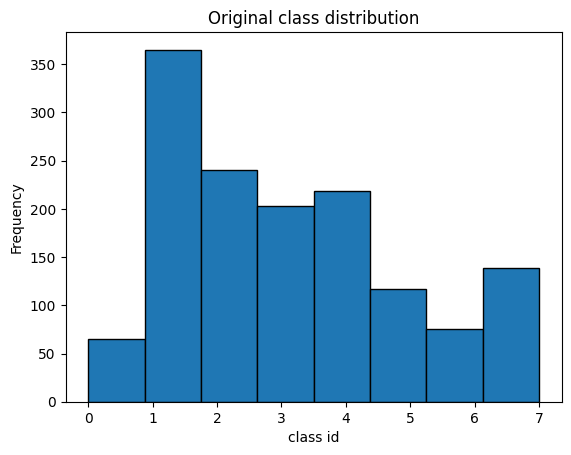

In [6]:
import matplotlib.pyplot as plt

plt.hist(data.targets, bins=len(data.classes), edgecolor='k')

plt.xlabel('class id')
plt.ylabel('Frequency')

plt.title('Original class distribution')

plt.show()

Очевидно, мы встретили сценарий, описанный в `2.1`

Посмотрим теперь, насколько удачно мы реализовали семплер

In [7]:
from data import BGDataModule

data = BGDataModule(
    data_dir=DATADIR,
    batch_size=BATCH_SIZE
)

data.setup('fit')

In [8]:
train_dataloader = data.train_dataloader()

In [9]:
buffer = []
for _, cls in train_dataloader:
    buffer += cls.tolist()

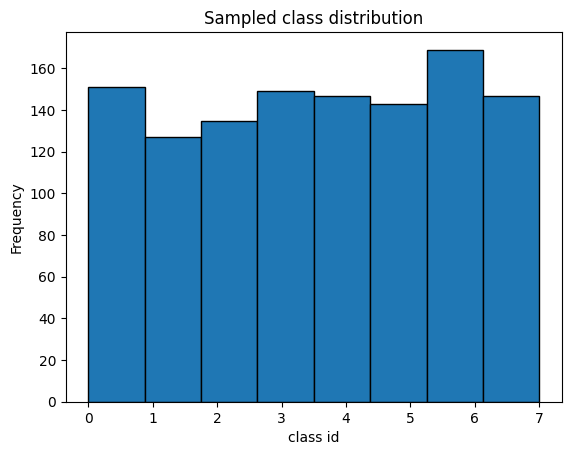

In [10]:
import matplotlib.pyplot as plt

plt.hist(buffer, bins=len(data.train_data.classes), edgecolor='k')

plt.xlabel('class id')
plt.ylabel('Frequency')

plt.title('Sampled class distribution')

plt.show()

Теперь все выглядит ровно

# `0.3`

Дальше посмотрим на получившиеся аугментации

In [11]:
batch = None

buffer = []
for batch in train_dataloader:
    break

len(batch)

2

In [12]:
import math

def plot_tensor(x, rows=1):

    _, axes = plt.subplots(
        figsize=(10, 5),
        ncols=5,
        nrows=min(math.ceil(x[0].shape[0] / 5), rows)
    )

    for i, ax in zip(range(x[0].shape[0]), axes.ravel()):

        sample = x[0][i]
        min_stats = sample.min(-2, keepdim=True).values.min(-1, keepdim=True).values
        max_stats = sample.max(-2, keepdim=True).values.max(-1, keepdim=True).values

        sample = (sample - min_stats) / (max_stats - min_stats)

        ax.imshow(sample.permute(1, 2, 0))

        cls_name = data.train_data.classes[x[1][i]]
        ax.set_title(cls_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

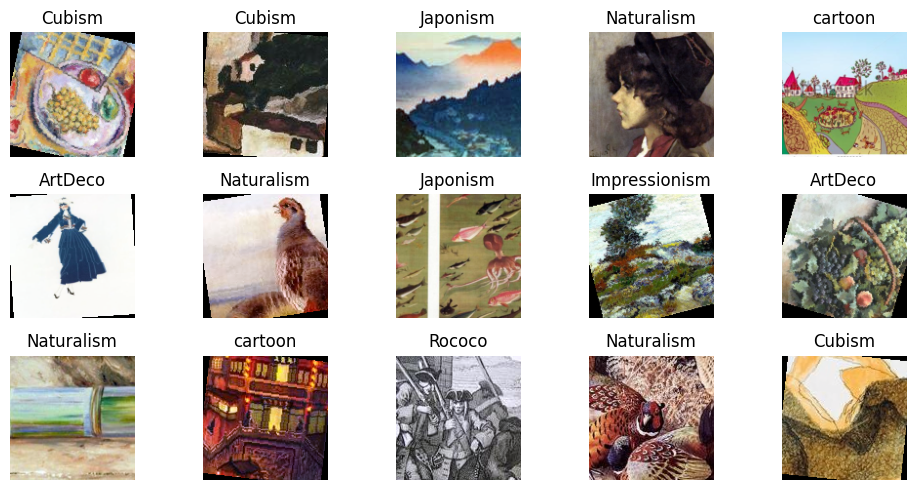

In [13]:
plot_tensor(batch, rows=3)

Видим, что контент и стиль не портятся по цвету после нормализации и кропов/поворотов -- ОК

# `1.` Вкратце про обучение

`1.1` Выбор пал на ранее успешный кейс 42-классовой классификации симпсонов -- претрейнт `ResNet50` -- глубокой сверточной нейронки

`1.2` Оптимизатор -- `AdamW`, по моему опыту для файнтюнинга важно использовать регуляризацию весов, эта версия `Adam`-а считается более правильной реализацией в контексте `weight_decay`, потому что слагаемое с весами используется напрямую в изменении весов модели, а не градиетов -- в случае `Adam`.

`1.3` `СrossEntropyLoss` -- расширение `BCE` для мультикласса

`1.4` `F1-score` -- гармоническое среднее `Precision` и `Recall` метрик -- хороший выбор для случая, когда у нас есть много моделей и мы хотим как-то ранжировать их качество относительно друг друга(у меня есть контрибьюшн в `sklearn`, я нашел ошибку в трактовке этой метрики в официальной доке :) ).

`1.5` Если покопаться в коде моей модели в `models.py`, то можно заметить, что все логируется в `wandb` -- будем смотреть на то, что получилось со сходимостью



<img src="../pics/losses.png" width="900" height="500"/>

Лоссы получились одного порядка, убывающие с небольшими осцилляциями -- модель сошлась

<img src="../pics/scores.png" width="900" height="500"/>

Метрики на трейне получились несильно выше, чем на валидации - ОК
Кривые не такие гладкие тк лоссы усреднялись по эпохам, а скоры по батчам

# `2.` Кластеризация эмбеддингов

Получим наши эмбеддинги для модели с весами самого удачного чекпоинта(другие веса у меня не сохраняются)

In [14]:
from models import ClassificationNet
import torch

In [15]:
model = ClassificationNet.load_from_checkpoint('../resnet50_separate_augs_unfreeze50_noblur_decay_1e-2_checkpoints/epoch=97-val_f1=0.825.ckpt')
# Убираем последний слой
model.model.fc = torch.nn.Identity()
model.eval()
pass

12092


Поскольку в будущем нам потребуются эмбеддинги как для трейна, так и для теста, то нет смысла сваливать все в кучу в один даталоадер -- поэтому я отказался от реализации этой логики в `data.py` модуле. Так же несмотря на фиксацию сида, не получится воспроизвести трейн для бустинга потому что аугментации применяются рандомно, но разбивку сохранить получится и ситуации с утечкой валидации в трейн мы избежим

In [16]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import augmentations

In [17]:
train_dataloader = DataLoader(
    dataset=Subset(
        ImageFolder(
            root=DATADIR,
            transform=augmentations.get_val_transform()
        ),
        data.train_idx
    ),
    batch_size=3 * BATCH_SIZE,
    pin_memory=True,
    num_workers=11
)

In [18]:
val_dataloader = DataLoader(
    dataset=Subset(
        ImageFolder(
            root=DATADIR,
            transform=augmentations.get_val_transform()
        ),
        data.val_idx
    ),
    batch_size=3 * BATCH_SIZE,
    pin_memory=True,
    num_workers=11
)

In [19]:
DEVICE = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
DEVICE

device(type='cuda')

In [20]:
model.to(DEVICE)
model.device

device(type='cuda', index=0)

In [21]:
import numpy as np
from tqdm.notebook import tqdm

In [22]:
# Теперь нам не надо считать градиенты    
@torch.no_grad()
def gen_embeds(fold=None, dataloader=None, save=False):

    assert type(fold) is str, 'fold should be string'

    buffer = []

    for x, cls in tqdm(dataloader):
            
        out = model(x.cuda()).cpu().numpy()
        
        buffer.append(np.concatenate([out, cls.unsqueeze(1)], axis=1))    

    res = np.concatenate(buffer, axis=0)

    if save:
        np.save(f'{fold}_embeds_tgt.npy', res)

    return res

In [50]:
# embeds = gen_embeds('train', train_dataloader, True)
# embeds = gen_embeds('val', val_dataloader, True)

train_embeds = np.load('train_embeds_tgt.npy')
val_embeds = np.load('val_embeds_tgt.npy')

train_tgt = train_embeds[:, -1]
train_embeds = train_embeds[:, :-1]

val_tgt = val_embeds[:, -1]
val_embeds = val_embeds[:, :-1]

train_embeds.shape, targets.shape, val_embeds.shape, val_tgt.shape

((1137, 2048), (1137,), (285, 2048), (285,))

In [51]:
embeds = np.concatenate([train_embeds, val_embeds])
targets = np.concatenate([train_tgt, val_tgt])

embeds.shape, targets.shape

((1422, 2048), (1422,))

 `2.1` Теперь для вычислительной эффективности нам нужно определить насколько мы можем позволить себе понизить размерность

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(embeds)
embeds_norm = scaler.transform(embeds)

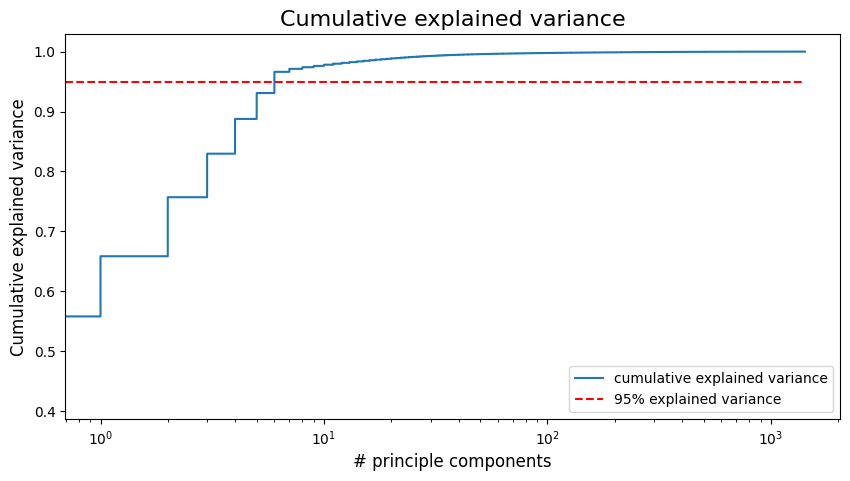

In [53]:
from sklearn.decomposition import PCA

pca = PCA(random_state=data.seed).fit(embeds_norm)

plt.figure(figsize=(10, 5))

plt.step(range(pca.components_.shape[0]), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance')

plt.hlines(y=0.95, xmin=0, xmax=len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')

plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.xscale('log')

plt.legend(loc='lower right')
plt.show()

Кажется, достатоточно взять 10 главных компонент для приемлемой потере по качеству. Убедимся, что это так, обучив логистическую регрессию для классификации

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [55]:
clf = LogisticRegression(n_jobs=-1, random_state=data.seed) 

n_comp_grid = np.arange(1, 9, 1).tolist() + np.arange(10, 200, 10).tolist()

scores_list = []

for n_comp in tqdm(n_comp_grid):

    pca = PCA(n_components=n_comp).fit(embeds_norm)
    
    x_train_ = pca.transform(embeds_norm)
    x_test_ = pca.transform(embeds_norm)

    clf.fit(x_train_, targets)
    y_pred = clf.predict(x_test_)

    scores_list.append(f1_score(targets, y_pred, average='weighted'))

  0%|          | 0/27 [00:00<?, ?it/s]

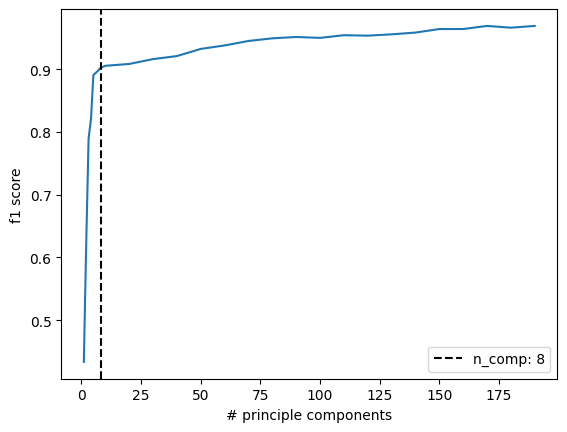

In [57]:
plt.plot(n_comp_grid, scores_list)

plt.axvline(8, linestyle='--', c='k', label = f'n_comp: 8')
plt.ylabel('f1 score')
plt.xlabel('# principle components')

plt.legend()
plt.show()

Интересное совпадение, что классификатор выдает максимальный перфоманс на 8 фичах, совпадающих по количеству с кол-вом классом. Let's stick to it. Из любознательности посмотрим как другие методы справляются с этой задачей с таким же гиперпараметром.

In [58]:
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.model_selection import RepeatedStratifiedKFold

In [73]:
N_DIM = 8

In [74]:
alg_list = [
    PCA(n_components=N_DIM),
    FastICA(n_components=N_DIM),
    Isomap(n_components=N_DIM)
]

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=data.seed)

scores = {}

for alg in tqdm(alg_list):

    new_data = alg.fit_transform(embeds_norm)

    model_name = type(alg).__name__

    scores[model_name] = []

    for train_id, test_id in rkf.split(new_data, targets):
    
        X_train, X_test = new_data[train_id], new_data[test_id]
        y_train, y_test = targets[train_id], targets[test_id]

        clf = LogisticRegression(n_jobs=-1, random_state=data.seed)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        scores[model_name].append(f1_score(y_test, y_pred, average='weighted'))

for alg_name in scores.keys():
    print(f'{alg_name}: {np.mean(scores[model_name]):.5f}')

  0%|          | 0/3 [00:00<?, ?it/s]

PCA: 0.88497
FastICA: 0.88497
Isomap: 0.88497


Остановимся на `PCA`

`2.2` Проведем сравнительных анализ алгоритмов кластеризации.

Поскольку после предпоследнего слоя фичи преобразуются линейно(`torch.nn.Linear`) и монотонно(`torch.nn.Softmax`) -- то не так важно, чтобы алгоритм кластеризации умел работать с линейно НЕ разделимыми множествами(потому что у нас уже есть не-линейные фичи), поэтому имеет смысл попробовать простейшие классы

In [61]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer

In [75]:
reduced_embeds = PCA(n_components=N_DIM).fit_transform(embeds_norm)

In [76]:
clustering_list = [
    KMeans(n_clusters=N_DIM, random_state=data.seed),
    AgglomerativeClustering(n_clusters=N_DIM),
    MiniBatchKMeans(n_clusters=N_DIM, random_state=data.seed),
    GaussianMixture(n_components=N_DIM, random_state=data.seed)
]

param_grid = [
    {
        'algorithm': ['lloyd', 'full', 'elkan'],
        'init': ['k-means++', 'random'],
        'n_init': ['auto']
     },
     {
        'linkage': ['complete', 'average', 'single'],
        'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'] 
     },
     {
        'init': ['k-means++', 'random'],
        'batch_size': [1024, 2048, 4056, 500],
        'n_init': ['auto']
     },
     {
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
     }
]

for i, clt in tqdm(enumerate(clustering_list)):

    print(f'{type(clt).__name__}:')
    
    if type(clt) is AgglomerativeClustering:
        
        results = []
        
        for params in ParameterGrid(param_grid[i]):

            y_pred = AgglomerativeClustering(n_clusters=15, **params).fit(reduced_embeds).labels_

            s_score = silhouette_score(targets.reshape(-1, 1), y_pred)
            m_score = adjusted_mutual_info_score(targets, y_pred)
            
            results.append((params, s_score, m_score))

        results = sorted(results, key=lambda x: x[2], reverse=True)
        s_score, m_score = results[0][1:]
        print('best params', results[0][0], sep=': ')

    else:

        gs_clt = GridSearchCV(clt, param_grid[i], n_jobs=-1, scoring='adjusted_mutual_info_score')
        gs_clt.fit(reduced_embeds, targets)

        y_pred = gs_clt.predict(reduced_embeds)

        s_score = silhouette_score(targets.reshape(-1, 1), y_pred)
        m_score = adjusted_mutual_info_score(targets, y_pred)

        print('best params', gs_clt.best_params_, sep=': ')

    print('silhouette_score', s_score.round(3), sep=': ')
    print('mutual_info_score', m_score.round(3), sep=': ')
    print()

0it [00:00, ?it/s]

KMeans:
best params: {'algorithm': 'lloyd', 'init': 'random', 'n_init': 'auto'}
silhouette_score: 0.335
mutual_info_score: 0.662

AgglomerativeClustering:
best params: {'linkage': 'average', 'metric': 'cosine'}
silhouette_score: 0.469
mutual_info_score: 0.698

MiniBatchKMeans:
best params: {'batch_size': 500, 'init': 'k-means++', 'n_init': 'auto'}
silhouette_score: 0.48
mutual_info_score: 0.707

GaussianMixture:
best params: {'covariance_type': 'full'}
silhouette_score: 0.504
mutual_info_score: 0.697



Посмотрим как ведут себя эти алгоритмы при варьировании кол-ва компонент

In [65]:
from sklearn.manifold import TSNE

0it [00:00, ?it/s]

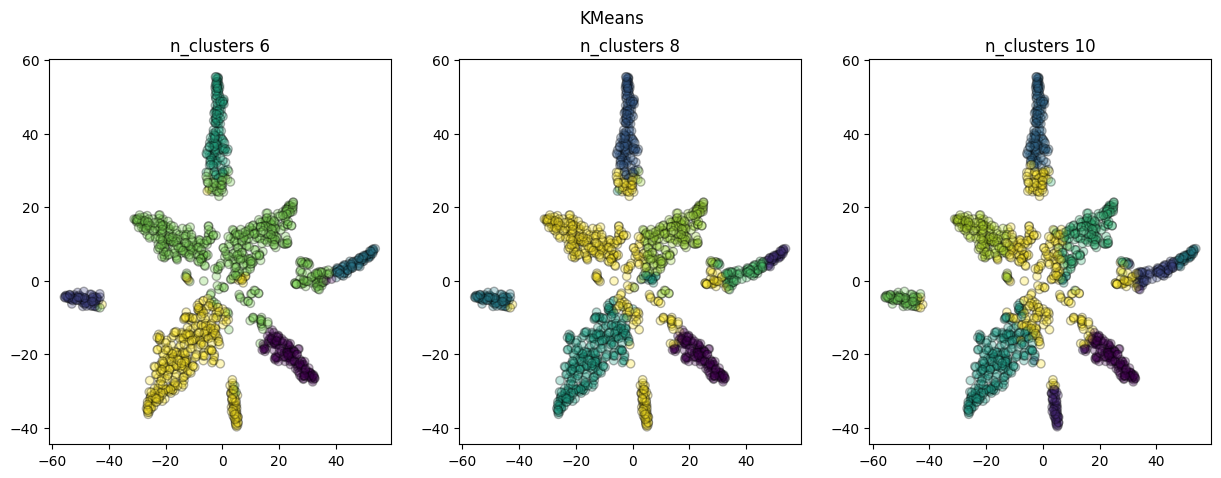

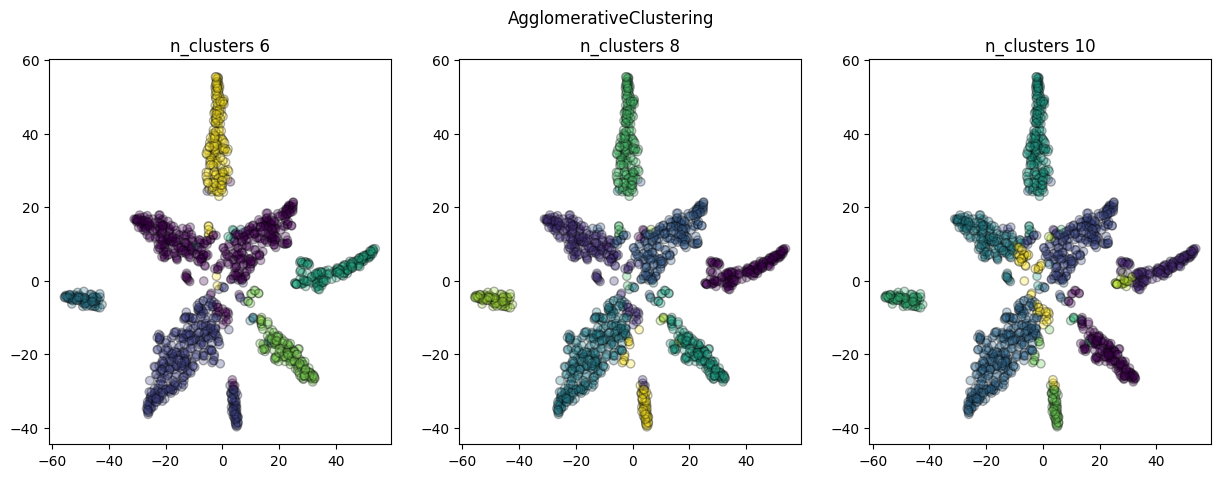

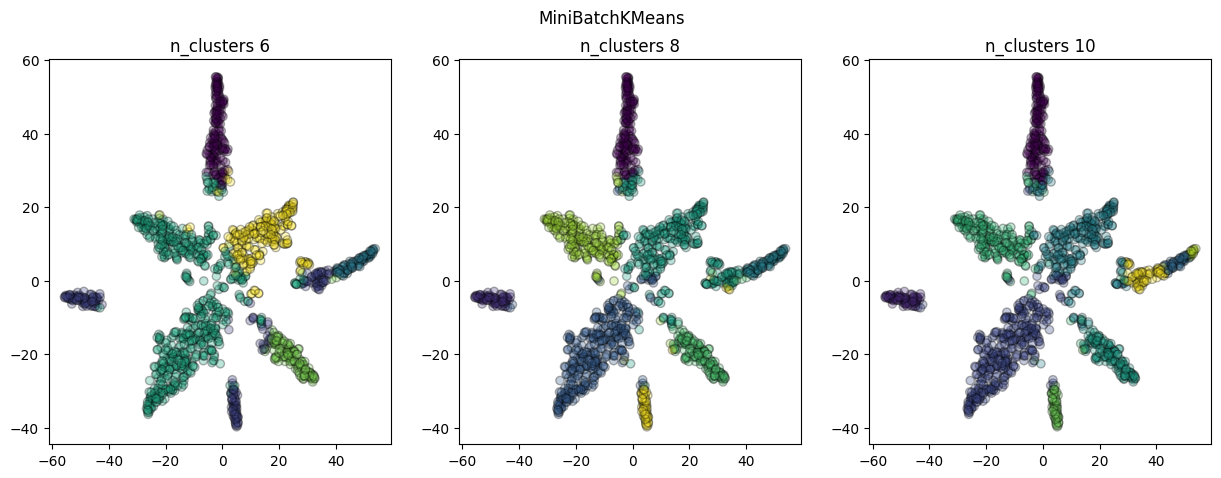

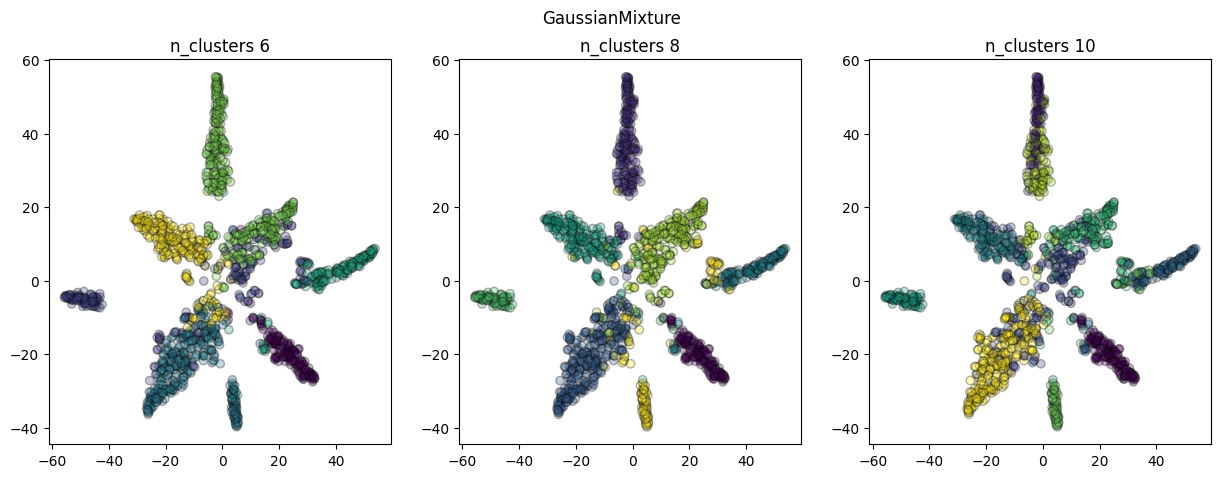

In [78]:
best_params = [
    {'algorithm': 'lloyd', 'init': 'random', 'n_init': 'auto', 'random_state': data.seed},
    {'linkage': 'average', 'metric': 'cosine'},
    {'batch_size': 500, 'init': 'k-means++', 'n_init': 'auto', 'random_state': data.seed},
    {'covariance_type': 'full', 'random_state': data.seed}
]

n_cluster_list = [N_DIM-2, N_DIM, N_DIM+2]

for i, clt in tqdm(enumerate(clustering_list)):

    _, axes = plt.subplots(figsize=(15, 5), ncols=3)

    plt.suptitle(type(clt).__name__)

    for n_clusters, ax in zip(n_cluster_list, axes.ravel()):
        
        labs = clt.__class__(n_clusters, **best_params[i]).fit_predict(reduced_embeds)

        coords = TSNE(2).fit_transform(reduced_embeds)
    
        ax.scatter(coords[:, 0], coords[:, 1], c=labs, alpha=0.3, edgecolor='k')
        ax.set_title(f'n_clusters {n_clusters}')

plt.show()

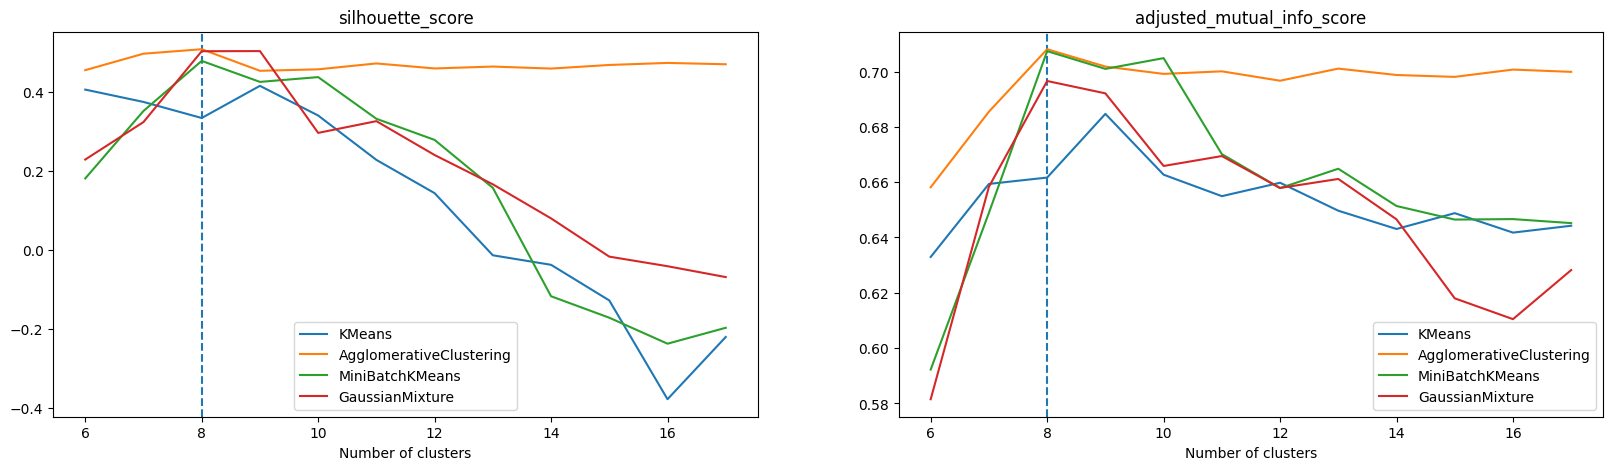

In [82]:
n_cluster_list = np.arange(N_DIM-2, N_DIM+10)

_, axes = plt.subplots(figsize=(20, 5), ncols=2)


axes_names = [
    'silhouette_score',
    'adjusted_mutual_info_score'
]

for i, ax_name in enumerate(axes_names):
    axes[i].set_title(ax_name)
    axes[i].set_xlabel('Number of clusters')
    axes[i].axvline(x=N_DIM, ymin=0, ymax=1, ls='--')

for i, clt in enumerate(clustering_list):

    s_list, m_list = [], []

    for n_clusters in n_cluster_list:
        
        labs = clt.__class__(n_clusters, **best_params[i]).fit_predict(reduced_embeds)        
    
        s_score = silhouette_score(targets.reshape(-1, 1), labs)
        m_score = adjusted_mutual_info_score(targets, labs)

        s_list.append(s_score)
        m_list.append(m_score)

    axes[0].plot(n_cluster_list, s_list, label=type(clt).__name__)
    axes[1].plot(n_cluster_list, m_list, label=type(clt).__name__)

[axes[i].legend() for i, _ in enumerate(axes_names)] 

plt.show()

Согласно метрикам, `AgglomerativeClustering` -- самый удачный из подходов

`2.3` Теперь перейдем к визуальной интерпретации полученных результатов

In [87]:
cluster_pred = AgglomerativeClustering(n_clusters=N_DIM, **{'linkage': 'average', 'metric': 'cosine'}).fit_predict(reduced_embeds)
cluster_pred.shape

(1422,)

In [94]:
import torchvision.transforms as TT

In [129]:
image_folder = datasets.ImageFolder(
    data.data_dir, transform=TT.Compose([
        TT.Resize((128, 128)),
        TT.ToTensor()
    ])
)

In [149]:
shuffled_indices = torch.cat([data.train_idx, data.val_idx]).numpy()
shuffled_indices.shape

(1422,)

In [152]:
def plot_cluster(cluster_id, nrows=1):

    assert cluster_id in set(cluster_pred), 'wrong cluster id'

    pred_ids = shuffled_indices[np.argwhere(cluster_pred==cluster_id)]

    _, axes = plt.subplots(
        figsize=(10, 5),
        ncols=5,
        nrows=min(math.ceil(pred_ids.shape[0] / 5), nrows)
    )

    for pred_id, ax in zip(pred_ids.squeeze(), axes.ravel()):

        sample = image_folder[pred_id][0]

        ax.imshow(sample.permute(1, 2, 0))

        cls_name = data.train_data.classes[image_folder[pred_id][1]]
        ax.set_title(f'true class: {cls_name}', fontdict={'fontsize': 8})
        ax.axis('off')

    plt.suptitle(f'Cluster # {cluster_id}')

    plt.tight_layout()
    plt.show()

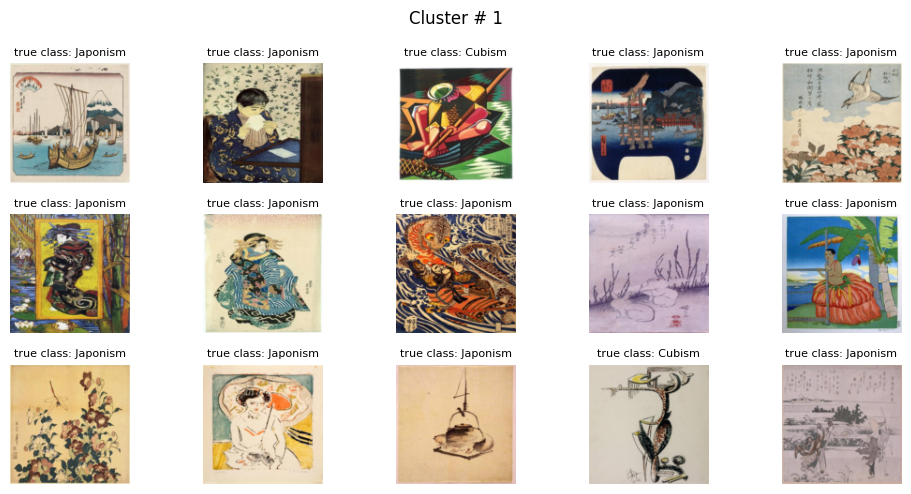

In [153]:
plot_cluster(
    cluster_id=1,
    nrows=3
)

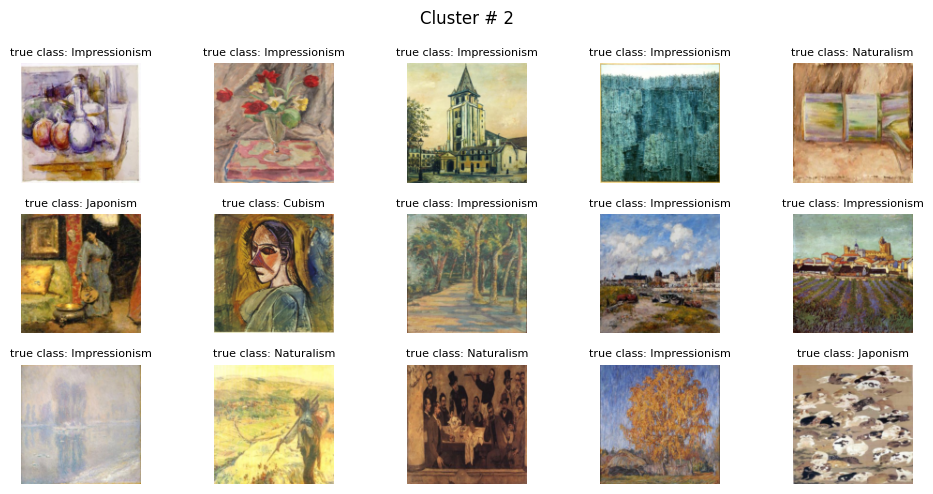

In [154]:
plot_cluster(
    cluster_id=2,
    nrows=3
)

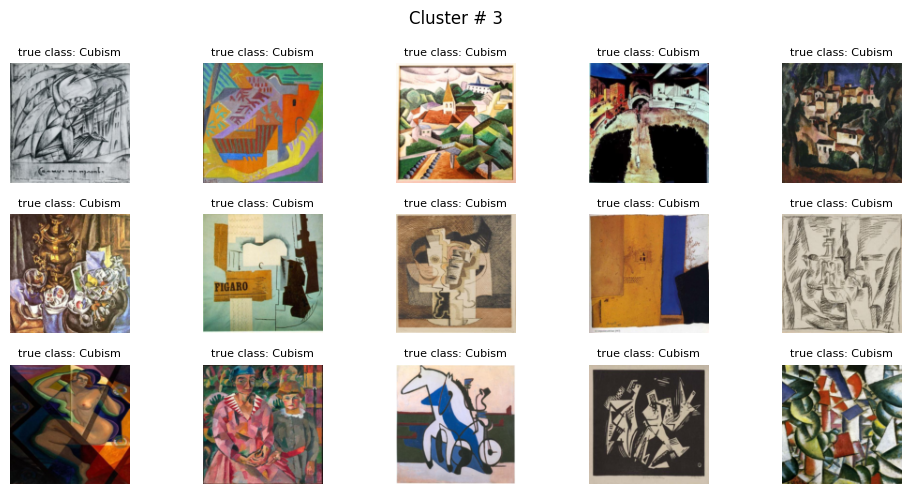

In [155]:
plot_cluster(
    cluster_id=3,
    nrows=3
)

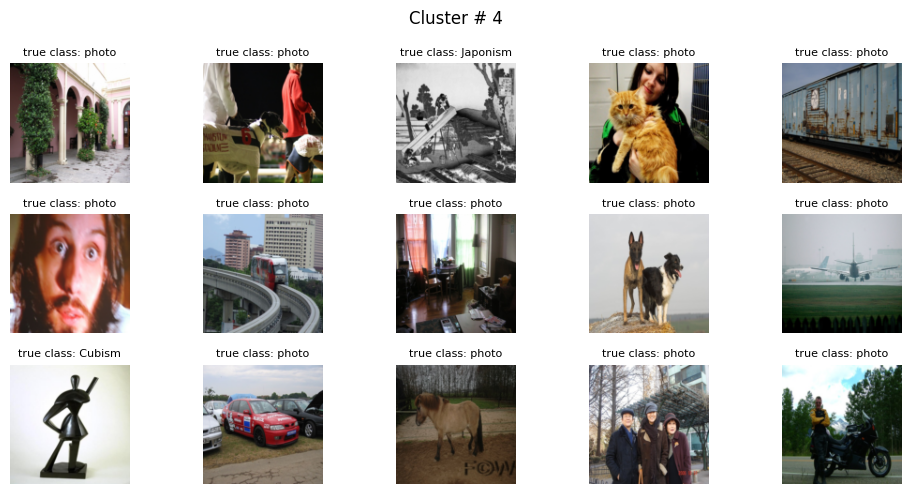

In [156]:
plot_cluster(
    cluster_id=4,
    nrows=3
)

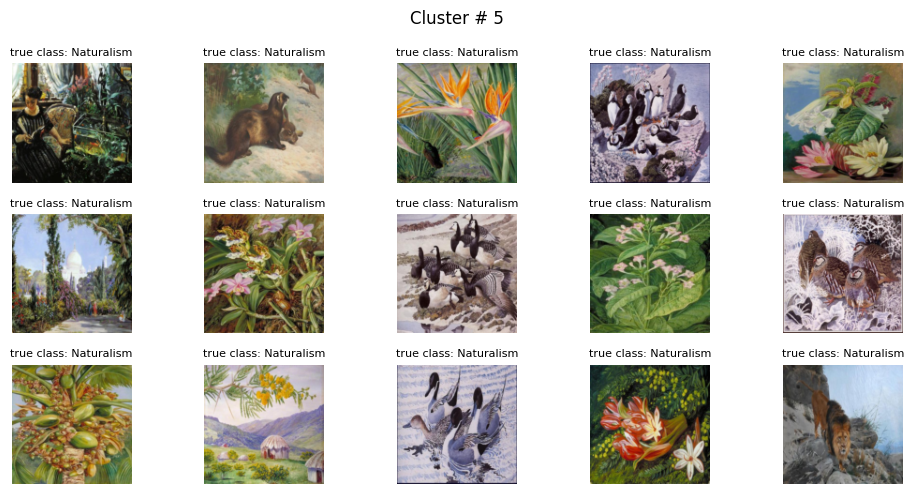

In [157]:
plot_cluster(
    cluster_id=5,
    nrows=3
)

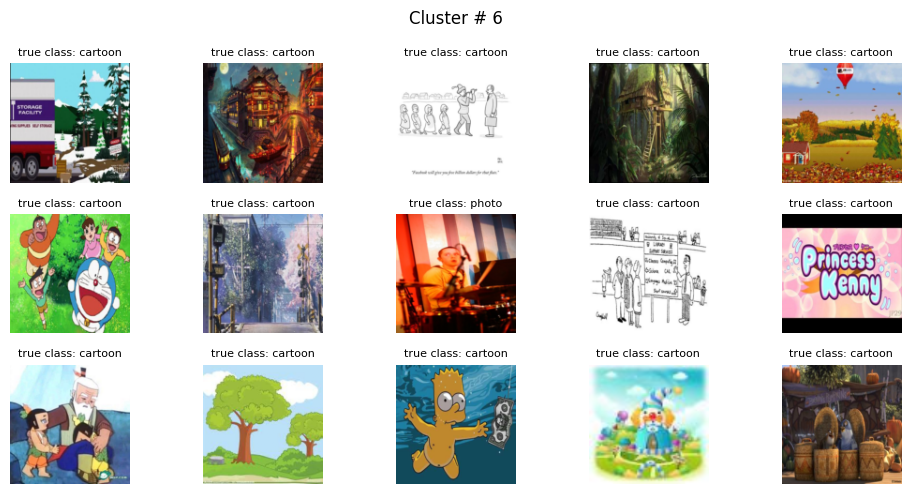

In [158]:
plot_cluster(
    cluster_id=6,
    nrows=3
)

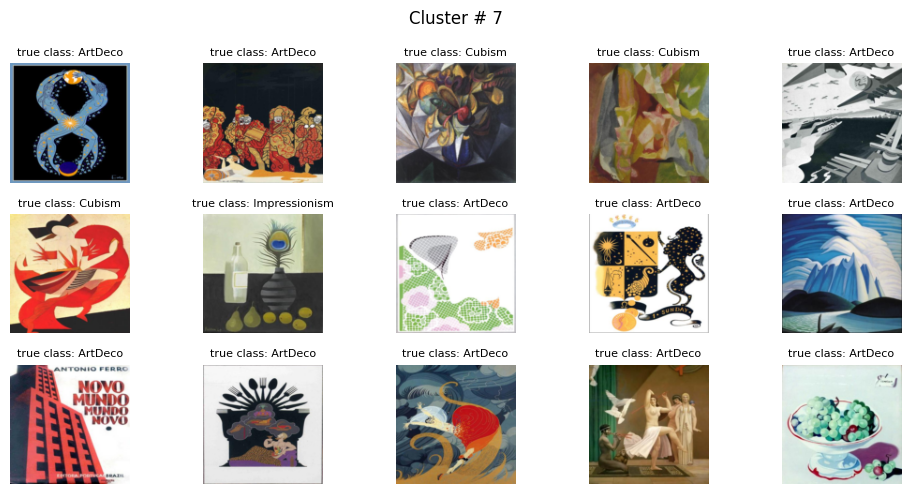

In [159]:
plot_cluster(
    cluster_id=7,
    nrows=3
)